In [1]:
import os, warnings
from functools import partial

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import geometry

# utils
from joblib import Parallel, delayed
from pandas import IndexSlice as idx
from IPython.display import display

# viz
import folium

# local imports
from spatial_interpolation import data, utils
from spatial_interpolation.visualization import map_viz
from spatial_interpolation.utils import tqdm_joblib

from experiments.noaa.machine_learning.feature_extraction import FeatureExtractionExperiment
from joblib import Parallel, delayed

import dotenv

# configs
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
dotenv.load_dotenv()

True

### Load the data available:

In [2]:
buoy_df, buoy_gdf = data.load_buoy_data(period=("2011-01-01", "2022-01-01"))
world_countries = data.load_world_borders()
world_countries = world_countries[world_countries.overlaps(geometry.box(*buoy_gdf.total_bounds.tolist()))]
# Remove the "buoys" that appear to be in land
land_buoys = buoy_gdf.geometry.apply(lambda x: any(world_countries.intersects(x,align=False)))
buoy_gdf = buoy_gdf[~land_buoys]
buoy_df = buoy_df[buoy_df.index.get_level_values("buoy_id").isin(buoy_gdf.index.get_level_values("buoy_id").unique())]

### Run Feature Extraction Experiment(s)

In [2]:
import subprocess
set_conf = "set1"
for y in range(2011,2022):
    experiment_name = FeatureExtractionExperiment.__name__
    p = subprocess.Popen(["python", "-m", "experiments", experiment_name , set_conf, f"--year={y}"])
    print(f"Started experiment {experiment_name} with config {set_conf} and year {y} on process {p.pid}")
    p.communicate()

Started experiment FeatureExtractionExperiment with config set1 on process 11014
Attempting to run experiment FeatureExtractionExperiment with config set1...
Running experiment FeatureExtractionExperiment with experiment_config='set1' and params: {'year': 2011}


INFO:FeatureExtractionExperiment:Loading data...
INFO:FeatureExtractionExperiment:Filtering data on area POLYGON ((-80 18.930645, -80 30.366655, -97.806644 30.366655, -97.806644 18.930645, -80 18.930645))
INFO:FeatureExtractionExperiment:Filtered data has shapes (1061321, 14) and (137, 4)
INFO:FeatureExtractionExperiment:Filtering data on year 2011
INFO:FeatureExtractionExperiment:Filtered data has shapes (109191, 14) and (14, 4)


Split test obtained with dataset(s)=['buoys_data'] and shape(s)=[(8736, 14)]


INFO:FeatureExtractionExperiment:Extracting features with num_jobs=25...
making features at each point..:  84%|████████▍ | 3242/3860 [00:34<00:06, 98.66it/s]]

All features made. Total number of features: 27. Number of points: 3856
All features made. Total number of features: 27. Number of points: 3744


making features at each point..:  87%|████████▋ | 3355/3860 [00:35<00:03, 149.73it/s]

All features made. Total number of features: 27. Number of points: 3860


making features at each point..:  90%|████████▉ | 3457/3860 [00:36<00:02, 163.22it/s]

All features made. Total number of features: 27. Number of points: 3855


making features at each point..:  90%|█████████ | 3491/3860 [00:36<00:02, 157.98it/s]

All features made. Total number of features: 27. Number of points: 3855


making features at each point..:  92%|█████████▏| 3558/3860 [00:36<00:01, 160.54it/s]

All features made. Total number of features: 27. Number of points: 3859


making features at each point..:  93%|█████████▎| 3593/3860 [00:36<00:01, 166.06it/s]

All features made. Total number of features: 27. Number of points: 2250


making features at each point..:  96%|█████████▌| 3702/3860 [00:37<00:00, 170.58it/s]

All features made. Total number of features: 27. Number of points: 3859


making features at each point..:  98%|█████████▊| 3778/3860 [00:38<00:00, 182.03it/s]

All features made. Total number of features: 27. Number of points: 3854


making features at each point..: 100%|██████████| 3860/3860 [00:38<00:00, 100.20it/s]


All features made. Total number of features: 27. Number of points: 3858
All features made. Total number of features: 27. Number of points: 3857
All features made. Total number of features: 27. Number of points: 3858
All features made. Total number of features: 27. Number of points: 3858
All features made. Total number of features: 27. Number of points: 3860
All features made. Total number of features: 27. Number of points: 3859
All features made. Total number of features: 27. Number of points: 3857
All features made. Total number of features: 27. Number of points: 3843
All features made. Total number of features: 27. Number of points: 3841
All features made. Total number of features: 27. Number of points: 3851
All features made. Total number of features: 27. Number of points: 3844
All features made. Total number of features: 27. Number of points: 3858
All features made. Total number of features: 27. Number of points: 3857
All features made. Total number of features: 27. Number of point

making features at each point..: 100%|██████████| 336/336 [00:05<00:00, 63.63it/s]


All features made. Total number of features: 27. Number of points: 336
All features made. Total number of features: 27. Number of points: 336


making features at each point..: 100%|██████████| 336/336 [00:04<00:00, 68.30it/s]


All features made. Total number of features: 27. Number of points: 335
All features made. Total number of features: 27. Number of points: 336
All features made. Total number of features: 27. Number of points: 336
All features made. Total number of features: 27. Number of points: 336
All features made. Total number of features: 27. Number of points: 336
All features made. Total number of features: 27. Number of points: 336
All features made. Total number of features: 27. Number of points: 336
All features made. Total number of features: 27. Number of points: 336
All features made. Total number of features: 27. Number of points: 335
All features made. Total number of features: 27. Number of points: 336
All features made. Total number of features: 27. Number of points: 336
All features made. Total number of features: 27. Number of points: 336
All features made. Total number of features: 27. Number of points: 336
All features made. Total number of features: 27. Number of points: 335
All fe

INFO:FeatureExtractionExperiment:Saving features...
INFO:FeatureExtractionExperiment:Finished running experiment "feature extraction"
/export/usuarios01/ssviloria/ml-spatial-interpolation/.venv/lib/python3.8/site-packages/joblib/externals/loky/backend/resource_tracker.py:303: UserWarning: resource_tracker: /dev/shm/joblib_memmapping_folder_11014_1a0bea44eea444f88731ead6cf689a30_ae2914abe0ac43f1a77ae153dcaf7798/11014-139937012732688-c7312df1b6ff491d80b29423cf17c765.pkl: FileNotFoundError(2, 'No such file or directory')
  warnings.warn(
/export/usuarios01/ssviloria/ml-spatial-interpolation/.venv/lib/python3.8/site-packages/joblib/externals/loky/backend/resource_tracker.py:303: UserWarning: resource_tracker: /dev/shm/joblib_memmapping_folder_11014_1a0bea44eea444f88731ead6cf689a30_ae2914abe0ac43f1a77ae153dcaf7798/11014-139937012732688-7fed6f7b4ffe4151b553bdaf749558c7.pkl: FileNotFoundError(2, 'No such file or directory')
  warnings.warn(


Started experiment FeatureExtractionExperiment with config set1 on process 12927
Attempting to run experiment FeatureExtractionExperiment with config set1...
Running experiment FeatureExtractionExperiment with experiment_config='set1' and params: {'year': 2012}


INFO:FeatureExtractionExperiment:Loading data...
INFO:FeatureExtractionExperiment:Filtering data on area POLYGON ((-80 18.930645, -80 30.366655, -97.806644 30.366655, -97.806644 18.930645, -80 18.930645))
INFO:FeatureExtractionExperiment:Filtered data has shapes (1061321, 14) and (137, 4)
INFO:FeatureExtractionExperiment:Filtering data on year 2012
INFO:FeatureExtractionExperiment:Filtered data has shapes (102864, 14) and (14, 4)


Split test obtained with dataset(s)=['buoys_data'] and shape(s)=[(7940, 14)]


INFO:FeatureExtractionExperiment:Extracting features with num_jobs=25...
making features at each point..: 100%|██████████| 3663/3663 [00:47<00:00, 76.77it/s] 


All features made. Total number of features: 27. Number of points: 3663
All features made. Total number of features: 27. Number of points: 3663
All features made. Total number of features: 27. Number of points: 3660
All features made. Total number of features: 27. Number of points: 2735
All features made. Total number of features: 27. Number of points: 3663
All features made. Total number of features: 27. Number of points: 3662
All features made. Total number of features: 27. Number of points: 3643
All features made. Total number of features: 27. Number of points: 3660
All features made. Total number of features: 27. Number of points: 3657
All features made. Total number of features: 27. Number of points: 3652
All features made. Total number of features: 27. Number of points: 3654
All features made. Total number of features: 27. Number of points: 3664
All features made. Total number of features: 27. Number of points: 3654
All features made. Total number of features: 27. Number of point

making features at each point..:  85%|████████▍ | 263/310 [00:02<00:00, 127.15it/s]

All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 309
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 309
All features made. Total number of features: 27. Number of points: 309
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 309


making features at each point..: 100%|██████████| 310/310 [00:02<00:00, 119.35it/s]


All features made. Total number of features: 27. Number of points: 309
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 287
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 310
All features made. Total number of features: 27. Number of points: 310
All fe

INFO:FeatureExtractionExperiment:Saving features...
INFO:FeatureExtractionExperiment:Finished running experiment "feature extraction"
/export/usuarios01/ssviloria/ml-spatial-interpolation/.venv/lib/python3.8/site-packages/joblib/externals/loky/backend/resource_tracker.py:303: UserWarning: resource_tracker: /dev/shm/joblib_memmapping_folder_12927_3eaac9999f4e43f587efa05e817d5900_487f1a92a6534ba6bc774ec467f6f9e1/12927-140228876254560-8d4d3a1cde924eebaf7d1d47e5fedeff.pkl: FileNotFoundError(2, 'No such file or directory')
  warnings.warn(
/export/usuarios01/ssviloria/ml-spatial-interpolation/.venv/lib/python3.8/site-packages/joblib/externals/loky/backend/resource_tracker.py:303: UserWarning: resource_tracker: /dev/shm/joblib_memmapping_folder_12927_3eaac9999f4e43f587efa05e817d5900_487f1a92a6534ba6bc774ec467f6f9e1/12927-140228876254560-e4658db7a49c4e19a7e1fbfe337fb347.pkl: FileNotFoundError(2, 'No such file or directory')
  warnings.warn(


Started experiment FeatureExtractionExperiment with config set1 on process 15002
Attempting to run experiment FeatureExtractionExperiment with config set1...
Running experiment FeatureExtractionExperiment with experiment_config='set1' and params: {'year': 2013}


INFO:FeatureExtractionExperiment:Loading data...
INFO:FeatureExtractionExperiment:Filtering data on area POLYGON ((-80 18.930645, -80 30.366655, -97.806644 30.366655, -97.806644 18.930645, -80 18.930645))
INFO:FeatureExtractionExperiment:Filtered data has shapes (1061321, 14) and (137, 4)
INFO:FeatureExtractionExperiment:Filtering data on year 2013
INFO:FeatureExtractionExperiment:Filtered data has shapes (119140, 14) and (14, 4)


Split test obtained with dataset(s)=['buoys_data'] and shape(s)=[(8126, 14)]


INFO:FeatureExtractionExperiment:Extracting features with num_jobs=25...
making features at each point..: 100%|██████████| 4303/4303 [01:13<00:00, 58.58it/s]


All features made. Total number of features: 28. Number of points: 4301
All features made. Total number of features: 28. Number of points: 4301
All features made. Total number of features: 28. Number of points: 4302
All features made. Total number of features: 28. Number of points: 4298
All features made. Total number of features: 28. Number of points: 4302
All features made. Total number of features: 28. Number of points: 4298
All features made. Total number of features: 28. Number of points: 4303
All features made. Total number of features: 28. Number of points: 4299
All features made. Total number of features: 28. Number of points: 4303
All features made. Total number of features: 28. Number of points: 4298
All features made. Total number of features: 28. Number of points: 4289
All features made. Total number of features: 28. Number of points: 4296
All features made. Total number of features: 28. Number of points: 4292
All features made. Total number of features: 28. Number of point

making features at each point..: 100%|██████████| 30/30 [00:00<00:00, 116.41it/s]


All features made. Total number of features: 28. Number of points: 29
All features made. Total number of features: 28. Number of points: 29
All features made. Total number of features: 28. Number of points: 29
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 30


making features at each point..:  77%|███████▋  | 23/30 [00:00<00:00, 107.14it/s]

All features made. Total number of features: 28. Number of points: 29
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 29
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 30


making features at each point..: 100%|██████████| 29/29 [00:00<00:00, 120.06it/s]


All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 29
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 30
All features made. Total number of features: 28. Number of points: 29
All features made. Total number of features: 28. Number of points: 29


INFO:FeatureExtractionExperiment:Saving features...
INFO:FeatureExtractionExperiment:Finished running experiment "feature extraction"
/export/usuarios01/ssviloria/ml-spatial-interpolation/.venv/lib/python3.8/site-packages/joblib/externals/loky/backend/resource_tracker.py:303: UserWarning: resource_tracker: /dev/shm/joblib_memmapping_folder_15002_ba5db181288548469ff8d3401b384269_5e1da2e9856541b0a847f7074ec7d22d/15002-140071959784512-4eb2e15205f1450a896bb096cd3eca1d.pkl: FileNotFoundError(2, 'No such file or directory')
  warnings.warn(
/export/usuarios01/ssviloria/ml-spatial-interpolation/.venv/lib/python3.8/site-packages/joblib/externals/loky/backend/resource_tracker.py:303: UserWarning: resource_tracker: /dev/shm/joblib_memmapping_folder_15002_ba5db181288548469ff8d3401b384269_5e1da2e9856541b0a847f7074ec7d22d/15002-140071959784512-b84feb15e61b4990b1c23a7702cdc903.pkl: FileNotFoundError(2, 'No such file or directory')
  warnings.warn(


Started experiment FeatureExtractionExperiment with config set1 on process 17024
Attempting to run experiment FeatureExtractionExperiment with config set1...
Running experiment FeatureExtractionExperiment with experiment_config='set1' and params: {'year': 2014}


INFO:FeatureExtractionExperiment:Loading data...
INFO:FeatureExtractionExperiment:Filtering data on area POLYGON ((-80 18.930645, -80 30.366655, -97.806644 30.366655, -97.806644 18.930645, -80 18.930645))
INFO:FeatureExtractionExperiment:Filtered data has shapes (1061321, 14) and (137, 4)
INFO:FeatureExtractionExperiment:Filtering data on year 2014
INFO:FeatureExtractionExperiment:Filtered data has shapes (97190, 14) and (14, 4)


Split test obtained with dataset(s)=['buoys_data'] and shape(s)=[(8223, 14)]


INFO:FeatureExtractionExperiment:Extracting features with num_jobs=25...
making features at each point..:  80%|███████▉  | 2778/3475 [00:36<00:06, 105.14it/s]

All features made. Total number of features: 28. Number of points: 3475


making features at each point..:  88%|████████▊ | 3060/3475 [00:37<00:03, 104.44it/s]

All features made. Total number of features: 28. Number of points: 3471


making features at each point..:  86%|████████▋ | 2998/3475 [00:38<00:04, 107.49it/s]

KeyboardInterrupt: 

making features at each point..:  92%|█████████▏| 3192/3475 [00:38<00:02, 106.40it/s]

making features at each point..:  92%|█████████▏| 3203/3475 [00:38<00:02, 104.69it/s]

All features made. Total number of features: 28. Number of points: 3465
All features made. Total number of features: 28. Number of points: 3458


making features at each point..:  94%|█████████▍| 3273/3475 [00:40<00:01, 176.72it/s]

All features made. Total number of features: 28. Number of points: 3472


making features at each point..:  96%|█████████▌| 3328/3475 [00:40<00:00, 177.72it/s]

All features made. Total number of features: 28. Number of points: 3471


making features at each point..:  98%|█████████▊| 3420/3475 [00:40<00:00, 179.87it/s]

All features made. Total number of features: 28. Number of points: 3462
All features made. Total number of features: 28. Number of points: 3475


making features at each point..: 100%|██████████| 3475/3475 [00:41<00:00, 84.42it/s] 


All features made. Total number of features: 28. Number of points: 3469
All features made. Total number of features: 28. Number of points: 3469
All features made. Total number of features: 28. Number of points: 3457
All features made. Total number of features: 28. Number of points: 3460
All features made. Total number of features: 28. Number of points: 3475
All features made. Total number of features: 28. Number of points: 3474
All features made. Total number of features: 28. Number of points: 3468
All features made. Total number of features: 28. Number of points: 3461
All features made. Total number of features: 28. Number of points: 3463
All features made. Total number of features: 28. Number of points: 3472
All features made. Total number of features: 28. Number of points: 3475
All features made. Total number of features: 28. Number of points: 3452
All features made. Total number of features: 28. Number of points: 3472
All features made. Total number of features: 28. Number of point

making features at each point..:  58%|█████▊    | 62/107 [00:00<00:00, 119.50it/s]

All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107


making features at each point..:  85%|████████▌ | 91/107 [00:00<00:00, 131.93it/s]]

All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107


making features at each point..: 100%|██████████| 107/107 [00:00<00:00, 122.07it/s]


All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 108
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 108
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107
All features made. Total number of features: 28. Number of points: 107


INFO:FeatureExtractionExperiment:Saving features...
INFO:FeatureExtractionExperiment:Finished running experiment "feature extraction"
/export/usuarios01/ssviloria/ml-spatial-interpolation/.venv/lib/python3.8/site-packages/joblib/externals/loky/backend/resource_tracker.py:303: UserWarning: resource_tracker: /dev/shm/joblib_memmapping_folder_17024_c8c7f45fd2de4cb4bf0ffcd710dbe1c0_fb70dad1a6de4fa385788244b907f2f6/17024-139741079373424-8fe4205ed94d4e03b7432dfca3fde8d2.pkl: FileNotFoundError(2, 'No such file or directory')
  warnings.warn(
/export/usuarios01/ssviloria/ml-spatial-interpolation/.venv/lib/python3.8/site-packages/joblib/externals/loky/backend/resource_tracker.py:303: UserWarning: resource_tracker: /dev/shm/joblib_memmapping_folder_17024_c8c7f45fd2de4cb4bf0ffcd710dbe1c0_fb70dad1a6de4fa385788244b907f2f6/17024-139741079373424-cd4078cd32244b239b23bdca97740ee5.pkl: FileNotFoundError(2, 'No such file or directory')
  warnings.warn(


In [4]:
def run_make_features_at_year(conf, year, **kwargs):
    experiment = FeatureExtractionExperiment(conf, year=year, **kwargs)
    experiment.set_data((buoy_df, buoy_gdf))
    _ = experiment.run()
    return _

In [ ]:
from IPython.utils import io

set_conf = "set1"
# with io.capture_output() as captured:
for y in range(2011,2022):
    print(f"Extracting features on {set_conf} for year {y}")
    run_make_features_at_year(set_conf, y, verbose=True)#, num_jobs=02)

### Analysis

In [ ]:
config = FeatureExtractionExperiment("set1").get_config()
train_df = pd.concat(
    [pd.read_parquet(f"{config.output.train_dir}/{year}.parquet") for year in range(2011,2022)],
    axis=0).sort_index()
test_df = pd.concat(
    [pd.read_parquet(f"{config.output.eval_dir}/{year}.parquet") for year in range(2011,2022)],
    axis=0).sort_index()

In [ ]:
locations_within_area = buoy_gdf.loc[buoy_gdf.within(config.area)].index.get_level_values("buoy_id").unique()
print("Training set:")
print("Shape:", train_df.shape)
print("All within area?",train_df.index.get_level_values("location_id").isin(locations_within_area).all())
print("Any eval buoys in train?",train_df.index.get_level_values("location_id").isin(config.locations_full).sum())
print("Any eval index in train?",train_df.index.isin(config.split_strategy.params.eval).sum())

print("Eval set:")
print("Shape:", test_df.shape)
print("All within area?",test_df.index.get_level_values("location_id").isin(locations_within_area).all())
print("Any eval buoys?",test_df.index.get_level_values("location_id").isin(config.locations_full).sum())
print("Any eval index?",test_df.index.isin(config.split_strategy.params.eval).sum())

Training set:
Shape: (926401, 23)
All within area? True
Any eval buoys in train? 0
Any eval index in train? 0
Eval set:
Shape: (66314, 23)
All within area? True
Any eval buoys? 64666
Any eval index? 66314


### Viz:

<AxesSubplot:title={'center':'Historical of Wave Height for Buoy 42019 Freeport, TX. 60 NM South of Freeport, TX.'}, xlabel='time'>

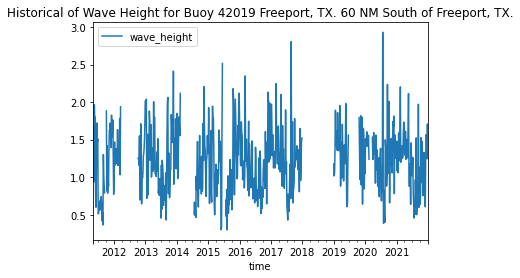

In [5]:
# pd.options.plotting.backend = "plotly"
fig = (
    buoy_df
    .loc[idx["42019","1995-01-01":],["wave_height"]]
    .loc["42019"]
    .resample("5D").mean()
    .plot(title=\
        f"Historical of Wave Height for Buoy {buoy_gdf.loc[2011,'42019'].buoy_name}",
        # labels=dict(value="Wave Height (meters)",variable=""),
    )
)
fig

In [20]:
set_1_buoys = ["41036","42040","42065","41041"]
entire_area = geometry.box(*(-98.251934,12.282308,-45,35.55)) 
area_1 = geometry.box(*(-97.3,18.930645,-81.2,30.366655))
area_2 = geometry.box(*(-82.836914,25.799891,-68.115234,35.55))
box1_gdf = gpd.GeoDataFrame({"geometry":[area_1.union(area_2)]},crs="epsg:4326")
outer_box_gdf = gpd.GeoDataFrame({"geometry":[entire_area]},crs="epsg:4326")

available_buoys = buoy_df.index.get_level_values("buoy_id").unique()
available_buoys_gdf = buoy_gdf.loc[buoy_gdf.index.get_level_values("buoy_id").isin(available_buoys)].reset_index()
uniques = buoy_gdf.loc[idx[:,set_1_buoys],:].reset_index().drop_duplicates(subset="buoy_id",keep="last").set_index("buoy_id")
mp = map_viz.make_map_of_buoys(
    location = available_buoys_gdf.unary_union.centroid.coords[0][::-1],
    zoom_start = 4,
    buoy_locations_df=available_buoys_gdf, 
    marker=partial(folium.CircleMarker, radius=1, weight=5,color="black"),
)
map_viz.add_geodf_to_map(uniques.loc[set_1_buoys],map=mp, color="red", radius=1, weight=5, layer_name="buoys from eval set 1")
area_1_gdf = gpd.GeoDataFrame({"geometry":[area_1]},crs="epsg:4326")
map_viz.add_geodf_to_map(utils.flip_coords(area_1_gdf),map=mp, layer_name="box2", color="yellow", alpha=0.5)
map_viz.add_geodf_to_map(utils.flip_coords(box1_gdf),map=mp, layer_name="box1",color="red")
map_viz.add_geodf_to_map(utils.flip_coords(outer_box_gdf),map=mp, layer_name="outer box", color="blue")
folium.LayerControl().add_to(mp)
mp

In [ ]:
# locations with the most data points
most_points = buoy_df[["wave_height","wind_direction"]].groupby(
    "buoy_id"
).count().sort_values(
    by=["wave_height","wind_direction","buoy_id"],
    ascending=False)
print("Locations with the most data points:")
display(most_points.head(10))
# times with the most data points
most_points = buoy_df[["wave_height","wind_direction"]].groupby(
    "time"
).count().sort_values(
    by=["wave_height","wind_direction","time"],
    ascending=False)
print("Times with the most data points:")
display(most_points.head(10))

Locations with the most data points:


,wave_height,wind_direction
buoy_id,,
41008,92660,92866
42012,89844,85012
41009,88162,86921
41043,86445,77620
41049,86397,81394
41044,85123,83200
41046,84803,85603
42055,84433,79456
42020,83648,82290


Times with the most data points:


,wave_height,wind_direction
time,,
2011-07-02 19:00:00,34,34
2011-07-02 18:00:00,34,34
2011-07-02 17:00:00,34,34
2011-07-02 16:00:00,34,34
2011-07-02 13:00:00,34,34
2011-07-01 18:00:00,34,34
2011-07-01 16:00:00,34,34
2011-07-01 15:00:00,34,34
2011-07-01 14:00:00,34,34


In [21]:
# within_box_buoys = buoy_gdf.loc[buoy_gdf.within(box1_gdf.unary_union)].index.get_level_values("buoy_id").unique()
# buoys_df_within = buoy_df.loc[buoy_df.index.get_level_values("buoy_id").isin(within_box_buoys)]
# prop_within_box = len(buoys_df_within.loc[set_1_buoys])/len(buoys_df_within)
# prop_within_outer = len(buoy_df.loc[set_1_buoys])/len(buoy_df)
# print(f"Proportion of eval data within box 1: {prop_within_box:.3f}")
# print(f"Proportion of eval data within outer box: {prop_within_outer:.3f}")

In [3]:
# variable = "wave_height"
# time = "2020-05-30 01:00" #buoy_df.index.get_level_values("time").max()
# map_viz.add_geodf_to_map(
#     buoy_df.loc[idx[:,time],:]
#         .join(buoy_gdf.loc[pd.Timestamp(time).year])
#         .dropna(subset=["wave_height","wind_direction"]),
#     radius=1,weight=5,
#     map_args={"zoom_start":4.5},
#     popup=lambda x: f"{x.buoy_name} {x.name}",
#     color = lambda x: "red" if x.name[0] in ["42019"] else "blue")

---